
## Print figures of coarsened Himawari cloud mask (distributed)


In [1]:
import os,sys
from glob import glob
#
import xarray as xr
from dask import compute, delayed
from dask.distributed import Client
# 
from datetime import datetime
#
from utils import *

/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py:121: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [2]:
### get dask handles and check dask server status
client = Client(scheduler_file=os.path.expanduser('/home1/datawork/aponte/dask/scheduler.json'))
client.restart()
# upload utils.py to workers
client.upload_file('utils.py')

In [3]:
client

Client Scheduler: tcp://10.148.1.18:8786 Dashboard: http://10.148.1.18:8787,Cluster Workers: 34 Cores: 136 Memory: 340.00 GB


In [5]:
# data path
dpath = '/home/datawork-lops-osi/data/hw/mask/';
figdir = '/home1/datawork/aponte/hw/figs/'

filenames = sorted(glob(dpath+'*.nc'))
print('Number of files available: %d' %len(filenames))
Nfiles = len(filenames)
# tmp, subset number of files (skip last file that may be incomplete)
filenames = filenames[:-1] 
print('Number of files processed: %d' %len(filenames))


Number of files available: 29780
Number of files processed: 29779


In [6]:
# coarsen factor [deg]
dl = 0.5
chunks={'longitude': 200}

def process(f,i):
    #
    time = datetime.strptime(f,dpath+'NC_H08_%Y%m%d_%H%M_L2CLPbet_FLDK.02401_02401.nc')
    figname = figdir+'hw_cmask_'+time.strftime('%Y%m%d_%H%M')+'.png'
    #
    if not os.path.isfile(figname):    
        # open file
        mask = xr.open_dataset(f)['QA']
        #s = str(mask)
        # massage the mask to get cloud flag
        fmask = process_raw_mask(mask)
        #mask.close()
        #del mask
        # coarsen fields
        cmask = coarsen(fmask, dl, chunks) # passes for 1000 files
        #s += str(cmask)
        #
        title = time.strftime('%Y%m%d_%H%M')
        #plot_mask(cmask['QA'], colorbar=False, title=str(time), savefig=figname) # str(time) breaks with exception was never retrieved: Traceback
        plot_mask(cmask['QA'], colorbar=False, title=title, savefig=figname) # crashes with colorbar=True
        #
        #m = float(fmask.mean().values)
        m = float(cmask['QA'].mean().values)
    else:
        m = -1.
    #
    #return s
    return m


In [7]:
values = [delayed(process)(f,i) for i,f in enumerate(filenames)]
results = compute(*values, get=client.get)
print(results[:10])

(-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0)


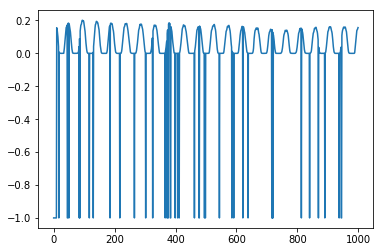

In [8]:
# plot first days of domain averaged values
import matplotlib.pyplot as plt
plt.figure()
plt.plot(results[:1000])
plt.show()

In [9]:
# make movie
print('ffmpeg -y -r 4 -pattern_type glob -i  \''+figdir+'hw_cmask*.png\'  hw_cmask.mp4')

ffmpeg -y -r 4 -pattern_type glob -i  '/home1/datawork/aponte/hw/figs/hw_cmask*.png'  hw_cmask.mp4
